# <center>Bayesian Particle Filtering for Parameter Estimation in SIR Models</center>

Particle filtering, also called Sequential Monte Carlo, is a family of algorithms popularized in the 1990's for solving estimation problems. The particle filter is used extensively in computer vision applications and has just recently been applied to parameter estimation problems in epidemiological modeling. 

The algorithm is used to estimate a partially observed state process, where the observations are proportional to the state process in some known way. In the image below the transmission model describes the state process, while the observation model describes the describes the observations which of proportional to the state process. 

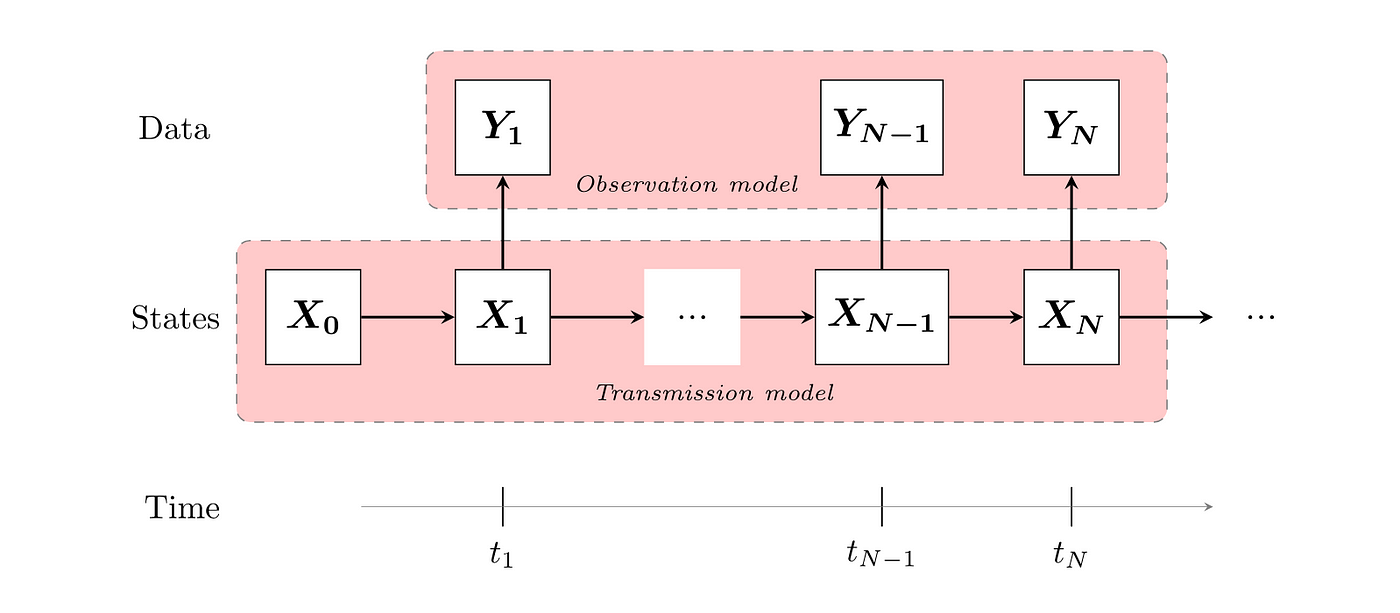

In our application of the particle filter, the state process is represented by the basic SIR model, with the observations being the number of new daily infections. 

### <center>State Model:</center> ###

$
\begin{align}
\frac{dS}{dt} &= -\beta\frac{SI}{N}\\\\ 
\frac{dI}{dt} &= \beta\frac{SI}{N}-\gamma\ I\\\\ 
\frac{dR}{dt} &= \gamma I\\\\
\end{align}
$


### <center>Observation Model:</center> ###

$
\begin{align}
b_t = \beta\frac{SI}{N}\
\end{align}
$

Note that $\b_t $ is the observed number of infections at any discrete time point t.

## <center>Description of the Particle Filtering Algorithm</center> ##

Intialize the particle swarm:
<br>
<br>
&emsp;&emsp; Draw $N$ values of $ \beta $ from a user defined prior distribution. eg. $ \beta_0^j \sim$ Uniform($[0,1]$) , $j \in N$
<br>
&emsp;&emsp;Define the initial state eg. $ z_0 = \begin{bmatrix} S_0 \\ I_0 \\ R_0 \\\end{bmatrix}$
<br>
&emsp;&emsp;In our initial implementation of the particle filter, we assume the initial state of the system is known, but the estimation problem can be extended to the initial state as well. 
<br>
&emsp;&emsp;Now define the initial particle swarm as $X_0 = \{x_0^1,x_0^2,\ldots, x_0^N\}, x_0^j = \begin{bmatrix} z_0 \\ \beta_0^j \\\end{bmatrix}$ and define a series of $N$ weights, one for &emsp;&emsp;each particles, whose values sum to 1. <br> &emsp;&emsp;$W_0 = \{w_0^1,w_0^2,\ldots,w_0^N \}, w_0^j = \frac{1}{N} $
<br>
<br>
&emsp;&emsp;Set $t=0.$

While $t < \text{tmax} $: <br><br>
(a) Propogate the $S,I,R$ components in vector $X$ from $t$ to $t+1$ according to the state process:<br>
    &emsp;&emsp;This gives the predictive particle swarm $\hat{X}_{t+1} = \{\hat{x}_{t+1}^1,\hat{x}_{t+1}^2,\ldots,\hat{x}_{t+1}^N \}$

(b) Extract the component $\beta\frac{SI}{N} $ of each particle and compute a series of temporany weights:<br>

 &emsp;&emsp;The weights $ \hat{G}_{t+1} = \{\hat{g}_{t+1}^1,\hat{g}_{t+1}^2,\ldots,\hat{g}_{t+1}^N\}$ are computed according to $\hat{g}_{t+1}^j = w_t^j \frac{(\beta\frac{SI}{N})^{b_{t+1}}}{b_{t+1}!}e^{-b_{t+1}}$. $ \hat{G}_{t+1} = \frac{\hat{G}_{t+1}}{\sum_{j=1}^{N}\hat{g}_{t+1}^j} $
 <br>
 &emsp;&emsp;As such, $b_{t+1}$ is assumed to be a poisson distributed random variable with expectation equal to $\beta\frac{SI}{N}$.
 <br>
 <br>
 (c) Sample with replacement $N$ indices, $\delta_j \in \{1,2,\ldots,N\}\,\ j = 1,2,\ldots, N$  using $\hat{G}_{t+1}$ as probabilites: 
 <br>&emsp;&emsp;Define the new resampled particle cloud $\hat{x}_{t+1}^j \leftarrow \hat{x}_{t+1}^{\delta_j}$<br>
 &emsp;&emsp;Generate a new particle cloud through the innovation process, $\log(X_{t+1}) = \mathcal{N}(\hat{X}_{t+1},C)$ where $C\in \R^4$ is a positive definite diagonal covariance matrix and 
 $\mathcal{N}$ is the multivariate normal distribution. 
  <br> &emsp;&emsp; For our testing $C = \begin{bmatrix} 
	\sigma_1^2/(S+I+R) & 0 & 0 & 0 \\
	0 & \sigma_1^2 & 0 & 0\\
	0 & 0 & \sigma_1^2 & 0\\
    0 & 0 & 0 & \sigma_2^2\\
	\end{bmatrix}$, where $\sigma_1$ is the variance of the state, $\sigma_2$ is the variance of $\beta$ and there is no covariance between variables. 

(d) From each new particle extract the component $\beta\frac{SI}{N} $ and evaluate the normalized likelihood: <br><br>
&emsp;&emsp; $G_{t+1} = \{g_{t+1}^1,g_{t+1}^2,\ldots,g_{t+1}^N \}$<br><br> &emsp;&emsp;$g_{t+1}^j = \frac{(\beta\frac{SI}{N})^{b_{t+1}}}{b_{t+1}!}e^{-b_{t+1}}$ <br><br>&emsp;&emsp;$ {G}_{t+1} = \frac{{G}_{t+1}}{\sum_{j=1}^{N} g_{t+1}^j} $ <br><br>
&emsp;&emsp;And update the weights:<br><br> &emsp;&emsp;&emsp;&emsp;$w_{t+1}^j = \frac{g_{t+1}^j}{\hat{g}_{t+1}^j}$
<br><br>
&emsp;&emsp;And advance the counter $t \leftarrow t+1$

## <center>Application of the Particle Filtering Algorithm</center> ##

To test the algorithm we have implemented it in python, using numpy.random and scipy.stats for statistical draws. The state process(SIR) is simulated using an euler integrator, defined in NumericalPropagator.py. Each call of propagate_euler() in the class one_step_propagator advances the state from $t$ to $t+1$. 

The algorithm itself is in Filtering.py, within the class ParticleFilter with functions to perform each step sequentially. The main function is estimate_params(time), where time is the length of the time series data for which we want to estimate parameters. 
<br><br>estimate_params(time) calls 4 functions to perform the various steps, propagate(),resample_with_temp_weights(), random_perturbations(), and norm_likelihood(). 
<br><br>
propagate() is a wrapper for propagate_euler() in one_step_propagator. <br><br>

resample_with_temp_weights(t) first calls a helper function compute_temp_weights(t) which computes the weights $\hat{G}_{t+1}$. It then uses these weights to compute new indexes for the particles and resamples with replacement accordingly. The index samples are drawn using np.random.choice().<br><br>

random_perturbations() randomly perturbs $S,I,R $, and $\beta$ according to the covariance matrix $C$. It normalizes then multiplies the state by the total population to ensure the perturbations don't change the total population from $t$ to $t+1$.<br><br>

norm_likelihood() is the final step of the algorithm, it computes the normalized likelihood without multplying by the weights $W_{t}$ and takes the ratio of these rates with those computed in compute_temp_weights() and updates $W_t$ accordingly. 


## <center>Results on Simulated Datasets</center> ##

To test the algorithm we generated two datasets, contained in observation_fixed_beta.csv and observations_variable_beta.csv. These datasets are numbers of daily infections generated using the same state process as above and known parameters, with random noise distributed according to $|\mathcal{N(\mu, \sigma^2 )}|$ with $\mu$ equal to $\frac{\beta S I}{N},$ and  $\sigma^2=40$. 
<br><br>

### <center>Static Parameters </center> ###

The first dataset is the simulated noisy observations for a fixed $\beta$ of $0.1$ and a $\gamma$ of $0.04$ with an initial state of $S=10000,I=100$, and $R=0$. 
















    
    
    







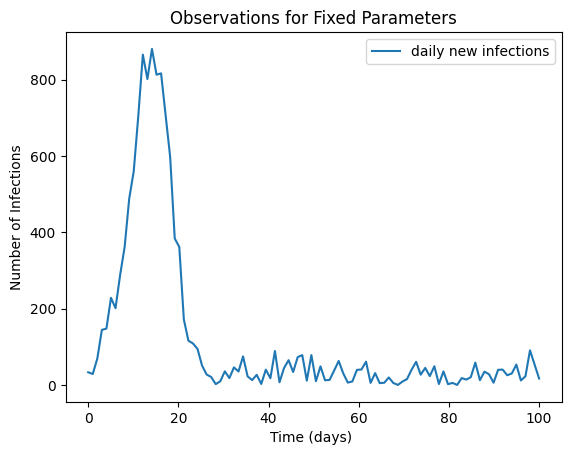

In [8]:
import pandas as pd; 
import matplotlib.pyplot as plt; 
import numpy as np; 

t = np.linspace(0,100,num=100); 
b_t = pd.read_csv('observations_fixed_beta.csv');
b_t = np.delete(b_t,0,1);

plt.xlabel("Time (days) ");
plt.ylabel("Number of Infections");
plt.title("Observations for Fixed Parameters");
plt.plot(t,b_t,label="daily new infections"); 
plt.legend(); 


The graph below is result of the algorithm. $5000$ particles are used as well as model parameters $\sigma_1 = 0.01 $ and $\sigma_2 = 0.1. $

The algorithm ran through the time series in $97$ seconds

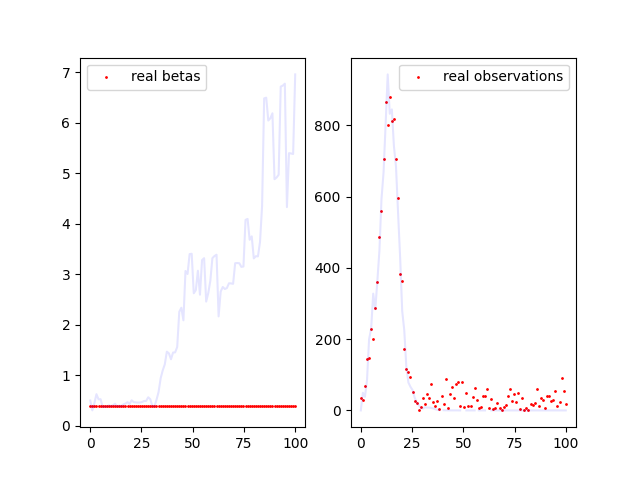

The estimates for $\beta $ diverge from the real $\beta$ around 25 days. I believe there are a few reasons for this, one is that because the algorithm uses a geometric random walk to perturb the parameters, when it struggles to converge the parameters will blow up quickly. Note that after day 25 in the real data the new infections fall to $0$, so when the algorithm sees the noisy data it can't make sense of it given the state variable $S$ having no one else viable for infection. The algorithm is highly dependent on the values of the hyperparameters $\sigma_1$ and $\sigma_2$,
which may improve convergence when tweaked. 

In the original paper an elaborate method for preventing the diffusion of static parameters as shown above is used. I will try to implement this in the future. 

### <center>Time Dependent Parameters</center> ###



The algorithm also works on $\beta$ as a function of time. The test data below was generated with  $\beta(t) =\frac{1}{2}e^{\frac{-(t-30)^2}{100}}$ with the same noise of $|\mathcal{N(\mu,\sigma^2)}|$ as above. 

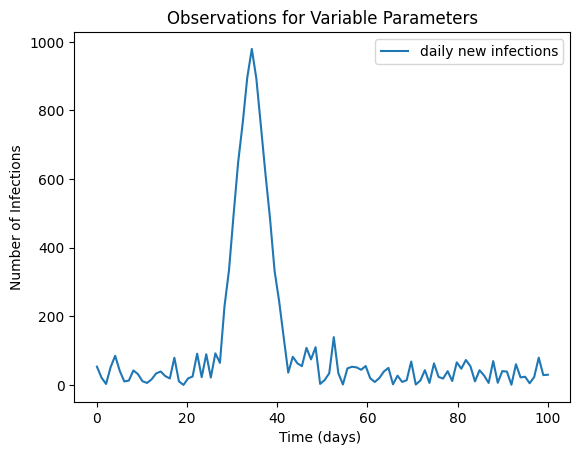

In [2]:
import pandas as pd; 
import matplotlib.pyplot as plt; 
import numpy as np; 

t = np.linspace(0,100,num=100); 
b_t = pd.read_csv('observations_variable_beta.csv');
b_t = np.delete(b_t,0,1);

plt.xlabel("Time (days) ");
plt.ylabel("Number of Infections");
plt.title("Observations for Variable Parameters");
plt.plot(t,b_t,label="daily new infections"); 
plt.legend(); 

The graph below is the result of the algorithm. $5000$ particles as used as well as hyperparameters $\sigma_1 = 0.01$ and $\sigma_2 = 0.1$.

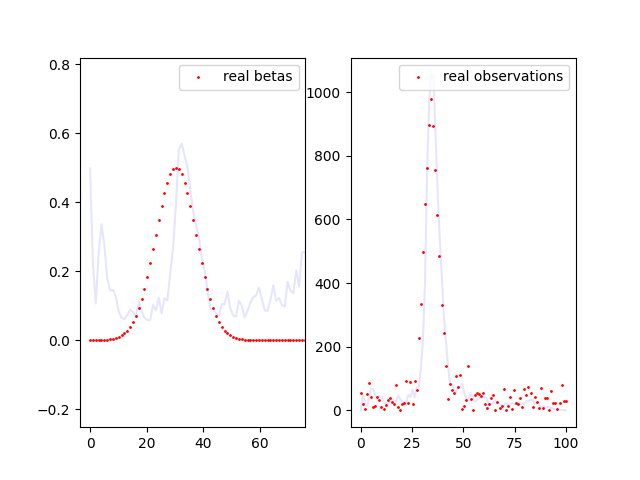

The algorithm provides reasonable estimates of $\beta(t)$ through the peak of the graph but struggles to provide coherent values of $\beta(t)$ towards the tails and blows up as described with the static parameters. 